<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y gensim

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0


In [2]:
!pip install gensim

     |████████████████████████████████| 24.1 MB 2.9 kB/s 


In [88]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px


In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

Full chords:

In [6]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y' -O input_seq.txt

--2021-11-07 18:57:53--  https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y
Resolving docs.google.com (docs.google.com)... 209.85.147.101, 209.85.147.113, 209.85.147.139, ...
Connecting to docs.google.com (docs.google.com)|209.85.147.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gq2qghdtagen38qrfr5682dforha6mrd/1636311450000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download [following]
--2021-11-07 18:57:54--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gq2qghdtagen38qrfr5682dforha6mrd/1636311450000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 142.250.128.132, 2607:f8b0:4001:c32::84
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14-4c-

Simplified chords:

In [7]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_' -O input_seq.txt

--2021-11-07 18:57:55--  https://docs.google.com/uc?export=download&id=1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_
Resolving docs.google.com (docs.google.com)... 209.85.147.101, 209.85.147.113, 209.85.147.139, ...
Connecting to docs.google.com (docs.google.com)|209.85.147.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jatvl1fq06e682leemqj78he5rmhi64t/1636311450000/14329102864480165501/*/1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_?e=download [following]
--2021-11-07 18:57:56--  https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jatvl1fq06e682leemqj78he5rmhi64t/1636311450000/14329102864480165501/*/1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_?e=download
Resolving doc-10-4c-docs.googleusercontent.com (doc-10-4c-docs.googleusercontent.com)... 142.250.128.132, 2607:f8b0:4001:c32::84
Connecting to doc-10-4c-docs.googleusercontent.com (doc-10-4c-

Meta Data:

In [8]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S' -O input_meta.csv

--2021-11-07 18:57:59--  https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S
Resolving docs.google.com (docs.google.com)... 209.85.147.100, 209.85.147.138, 209.85.147.139, ...
Connecting to docs.google.com (docs.google.com)|209.85.147.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u4sa5n9k5lq1jmujdeaom5ukq08rs4qt/1636311450000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download [following]
--2021-11-07 18:57:59--  https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u4sa5n9k5lq1jmujdeaom5ukq08rs4qt/1636311450000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download
Resolving doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.googleusercontent.com)... 172.253.114.132, 2607:f8b0:4001:c32::84
Connecting to doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-

In [9]:
path_to_file = '/content/input_seq.txt'

with open(path_to_file) as f: 
  lines = f.read().splitlines()

In [10]:
data = [line.split(' ') for line in lines]

### Meta Data

In [140]:
meta = pd.read_csv('input_meta.csv', sep='\t')
meta.columns

Index(['id', 'file_name', 'title', 'composer', 'year', 'year_truncated',
       'tonality', 'tune_key', 'tune_mode', 'structure', 'num_bars',
       'time_signature', 'cycle_fifths_order', 'style', 'musicbrainz_id',
       'wikidata_id', 'wikidata_allmusic', 'wiki_link', 'wikidata_description',
       'lyricist'],
      dtype='object')

In [194]:
titles = meta.loc[:, ['id', 'title', 'tune_mode']].drop_duplicates()
titles.set_index('id', inplace=True)

In [195]:
assert len(data) == len(titles)

# Chord N-Grams



In [150]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [151]:
def list_to_ngrams(data, n=2, sep='-'):
  out = []
  for row in data:
    out.append(ngrams(row, n, sep))

  return out

In [152]:
data_ngrams = list_to_ngrams(data, 3)

In [153]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

In [154]:
df_chords = raw_chords_to_df(data_ngrams)
df_chords.head(10)

,chord,count
14,Dm7-G7-CM7,1628
76,G7-C-C,1471
136,A7-Dm7-G7,1427
900,C-C-C,1056
184,Dm7-G7-C6,996
86,G7-G7-C,967
135,Em7-A7-Dm7,828
862,D7-G7-C,760
182,A7-D7-G7,742
71,Am7-Dm7-G7,650


In [155]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

# Word Embeddings

In [156]:
from gensim.models import word2vec


In [157]:
train_data = data_ngrams
EMBED_SIZE = 100

In [158]:
# train model
model = gensim.models.Word2Vec(train_data, 
                               vector_size=EMBED_SIZE,
                               min_count=1,
                               sample=0.1,
                               sg=1,
                               window=3,
                               negative=5,
                               epochs=50,
                               alpha=0.025,
                               )

2021-11-07 21:15:47,835 : INFO : collecting all words and their counts
2021-11-07 21:15:47,837 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-07 21:15:47,868 : INFO : collected 13442 word types from a corpus of 89538 raw words and 2046 sentences
2021-11-07 21:15:47,870 : INFO : Creating a fresh vocabulary
2021-11-07 21:15:47,939 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 13442 unique words (100.0%% of original 13442, drops 0)', 'datetime': '2021-11-07T21:15:47.939164', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-07 21:15:47,941 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 89538 word corpus (100.0%% of original 89538, drops 0)', 'datetime': '2021-11-07T21:15:47.941494', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'plat

In [159]:
# summarize vocabulary
vocab = model.wv.index_to_key
print(vocab)

['Dm7-G7-CM7', 'G7-C-C', 'A7-Dm7-G7', 'C-C-C', 'Dm7-G7-C6', 'G7-G7-C', 'Em7-A7-Dm7', 'D7-G7-C', 'A7-D7-G7', 'Am7-Dm7-G7', 'C-G7-C', 'G7-G7-G7', 'C-C-G7', 'Dm7-G7-C', 'D7-G7-G7', 'C-C7-F', 'D7-Dm7-G7', 'D7-D7-G7', 'Gm7-C7-FM7', 'C-G7-G7', 'G7-Dm7-G7', 'Bm7b5-E7-Am7', 'Dm7-G7-Dm7', 'G7-CM7-CM7', 'C-A7-D7', 'Dm7-G7-Em7', 'G7-C-G7', 'A7-D7-D7', 'G7-C-C7', 'C7-F-F', 'C-F-C', 'Am7-D7-Dm7', 'C7-C7-C7', 'G7-Em7-A7', 'G7-C6-C6', 'E7-Am7-D7', 'F-Fm-C', 'CM7-Am7-Dm7', 'C6-Dm7-G7', 'A7-A7-D7', 'Em7b5-A7-Dm7', 'Am7-Am7-Am7', 'Ebdim7-Dm7-G7', 'CM7-A7-Dm7', 'G7-CM7-Am7', 'G7-C6-Dm7', 'CM7-Dm7-G7', 'G7-C-F', 'F-C-C', 'E7-Am-Am', 'C-C-F', 'E7-A7-A7', 'CM7-CM7-CM7', 'G7-CM7-Dm7', 'Am7-D7-G7', 'D7-G7-C6', 'CM7-Gm7-C7', 'D7-D7-D7', 'F-F-C', 'C-C-C7', 'E7-Am7-Am7', 'C7-F-Fm', 'C6-Am7-Dm7', 'G7-CM7-A7', 'C-C-D7', 'C7-FM7-Bb7', 'Am-Am-Am', 'Dm7-G7-G7', 'Bm7b5-E7-Am', 'G7-C6-Am7', 'F-F#dim-C', 'C#dim7-Dm7-G7', 'G7-CM7-F7', 'G7-Gm7-C7', 'D7-G7-CM7', 'F#m7b5-B7-Em7', 'Em7-Am7-Dm7', 'Em7-Ebdim7-Dm7', 'C7-C7-F', 

In [160]:
weights = model.syn1neg

In [161]:
print(weights.shape)
vec_df = pd.DataFrame(weights, index=vocab)
vec_df.head()

(13442, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Dm7-G7-CM7,-0.616325,0.286722,0.568686,-0.649922,0.696979,0.927523,0.500089,-0.999163,-0.551282,0.284909,0.633964,-0.857535,0.196047,0.536222,0.330620,0.360311,-0.372338,-0.271909,-0.375271,0.709000,0.357244,0.270266,0.060528,0.223012,-0.792666,0.762402,-0.958951,-0.721464,-0.054214,0.110714,0.395461,0.167750,-0.471144,0.106468,-0.178174,0.014835,-0.058110,-0.079629,-0.380979,0.704543,...,0.254564,-0.252032,0.600447,0.429795,0.971479,0.534693,-0.976760,-1.372980,1.394495,-0.676446,0.011174,0.389181,-0.278919,0.288420,0.257353,-0.805300,-0.269988,-0.271558,0.441861,0.387696,-0.299693,0.222026,0.477935,-0.112559,-0.226870,0.361649,0.002017,-1.224326,0.523530,-0.584976,-0.320727,0.622235,-0.993781,0.122218,-0.731880,-0.550050,0.065366,0.471045,-0.330020,0.310114
G7-C-C,0.229771,0.385853,-0.388501,0.017581,0.113938,0.294629,0.133039,-1.110972,-0.575857,0.049984,0.675532,-1.010434,0.274573,-1.291279,0.537439,0.007685,-0.365620,0.144285,-0.460736,0.884168,0.452348,-0.408868,0.041404,0.560842,-1.206878,-0.395010,0.396980,-0.720796,0.892142,-0.246165,0.353823,-0.536431,0.344000,0.450043,0.283101,0.634142,-0.276350,0.129041,-0.455889,0.298430,...,0.173327,-0.429451,-0.384185,-0.880536,0.359216,0.864230,-0.131723,1.076406,0.364029,-0.535569,0.332403,0.207777,0.345340,0.617901,0.259678,0.525957,-0.169850,-0.098692,0.510683,-0.401652,-0.613342,0.934767,0.760576,-0.568494,-0.218819,0.485152,-0.263606,-0.067964,0.931113,0.057602,0.075662,-0.524677,0.004511,-0.168847,0.102374,-0.334769,-0.480122,-0.172313,0.205854,0.440320
A7-Dm7-G7,0.205008,0.205449,-0.024308,-0.378234,-0.666294,0.771712,0.950329,-0.836216,-0.768538,-0.464533,0.745078,-0.089219,0.455730,0.828347,-1.223686,0.079655,-0.366161,0.007123,1.202139,0.717076,0.649373,-0.522703,-0.030640,0.181728,-1.389934,0.133988,-0.028544,-0.911353,0.277130,0.522264,0.185928,0.316691,0.085763,-0.912306,-0.460980,0.089833,-0.134191,-0.103318,-0.594291,0.824820,...,-0.794007,0.533150,0.430376,-0.435372,0.856317,-0.841873,0.153701,-0.659140,0.804012,-1.432448,-0.337949,-0.715667,-0.737897,0.893258,-0.277070,-0.221692,-0.794082,0.345477,0.030442,0.134279,-0.012823,1.008760,-0.440896,0.219191,0.098128,-1.080653,1.434468,0.081575,0.443590,0.311525,-0.105063,-0.452007,-0.539869,-0.623939,-0.933928,-0.742801,-0.266798,0.151664,-0.533325,0.868933
C-C-C,0.598361,1.414086,0.563217,-0.226280,-0.487457,-0.400440,0.294331,-0.633939,-0.839284,0.065199,0.805440,-0.589598,0.465844,-0.986699,0.851403,-0.307666,-0.235031,-0.025338,-0.450130,1.092732,0.383636,0.175185,0.026865,1.192138,-1.226567,0.347383,-0.149846,-0.067115,0.912216,-0.130340,-0.421630,-0.741028,-0.005140,0.088380,-0.102651,0.018608,0.173365,0.143255,0.006866,0.981554,...,-0.422891,-0.111612,0.259453,-0.377944,-0.253724,0.262979,-0.384249,1.183692,0.703161,-0.890253,-0.405772,-0.277518,0.290581,0.953883,-0.364946,-0.412674,-0.665319,-0.069782,0.542724,-0.138268,-0.892000,0.755821,0.566399,0.072375,0.459584,0.668684,0.342016,0.153059,1.101036,0.169451,0.573112,-0.588296,-0.207222,-0.365214,0.160640,0.352550,-0.116598,-0.441859,-0.063803,-0.171554
Dm7-G7-C6,0.162542,-0.881032,-0.374467,-0.363270,0.067325,0.792770,-0.313936,-0.830820,0.753399,-0.071103,0.174533,-0.565677,-0.423050,0.307365,0.302698,0.005678,-0.485702,-0.089296,0.198289,0.887068,0.335186,0.788308,-0.450860,0.191343,-1.190682,-0.091010,0.089635,-1.209636,0.262376,-0.370582,-0.221102,0.740250,-0.470643,0.563876,-0.460189,0.033176,0.444707,0.091156,-0.462217,1.611273,...,-0.216038,-0.529300,0.377626,0.442930,0.565820,0.666877,0.431622,0.046188,0.135024,-0.247373,1.156820,0.422852,-0.271327,0.585977,0.102896,0.205541,-0.446344,-0.376829,-0.421011,1.475975,-0.302947,0.147844,-0.642391,0.261409,0.517238,0.198062,0.102224,-0.264307,0.899363,-0.661429,0.132143,0.6

### Visualize the embedding weight for each chord ngram


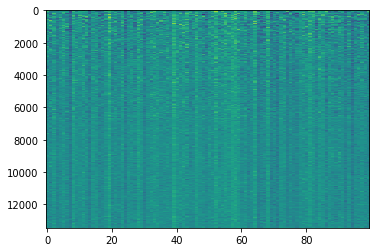

In [165]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(weights, interpolation='nearest')
ax.set_aspect(0.005)

In [166]:
vocab_set = set(vocab)
model_dict = dict(zip(vocab, weights))

## Calculate embeddings for Tunes


In [167]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
  vocabulary = vocab_set

  features = []
  for tune in corpus:
    features.append(average_word_vectors(tune, 
                                         model, 
                                         vocabulary, 
                                         num_features)
    )

  return np.array(features)

In [168]:
# get document level embeddings
corpus = data_ngrams
num_features = EMBED_SIZE

ft_doc_features = averaged_word_vectorizer(corpus=corpus, 
                                           model=model_dict,
                                           num_features=num_features)

df_features = pd.DataFrame(ft_doc_features)

In [169]:
df_features.shape

(2046, 100)

In [170]:
df_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.003630,-0.524929,0.426866,-0.242253,-0.152052,0.028052,-0.035639,-0.410751,0.272571,-0.338175,0.081177,0.156374,-0.340445,-0.384284,0.250483,0.443309,-0.214982,-0.048417,0.021192,0.586995,-0.091668,0.058598,-0.499236,0.183589,-0.515338,0.213484,-0.291889,-0.006543,0.374524,-0.120335,-0.387488,-0.111015,0.120473,0.488383,0.110904,0.136680,0.172552,-0.324585,-0.420171,1.074501,...,0.021622,0.386652,0.238820,-0.178391,0.837616,-0.479324,-0.157407,-0.516609,0.776253,-0.894365,-0.357097,-0.260735,-0.461820,-0.020244,-0.244220,-0.245237,-0.380458,0.046372,0.077981,0.067874,0.018650,0.534036,0.224680,0.008903,0.076452,0.271578,-0.181475,-0.342672,0.085303,-0.862716,-0.127702,0.290007,-0.813409,0.300304,-0.154497,-0.289040,0.155328,-0.111774,-0.189853,0.109851
1,0.021423,-0.100354,-0.022919,-0.389240,-0.125017,0.187270,-0.063112,-0.369216,0.382973,0.107426,-0.123190,0.218412,0.020974,-0.406889,0.232108,-0.060594,-0.188400,-0.337815,0.060941,0.314785,-0.358268,-0.114294,-0.196636,0.107862,-0.197366,0.015631,0.038046,0.023189,0.179468,0.113586,-0.200035,-0.061447,-0.048171,0.034652,-0.092800,-0.018091,0.037274,0.037384,0.103325,0.422798,...,0.044130,0.125260,-0.267683,-0.031530,0.319927,-0.409439,-0.112509,-0.205312,0.366738,-0.299764,-0.087190,-0.306814,-0.000397,-0.021047,-0.295839,-0.152107,-0.008764,0.014131,0.100653,0.023437,0.260897,0.445251,0.003155,-0.151483,0.305444,0.150097,-0.322801,0.193881,-0.193646,-0.104189,0.129991,0.093014,-0.295918,0.138875,-0.585252,0.075798,0.028320,-0.080350,-0.166349,-0.095870
2,0.096461,-0.516775,0.186277,-0.343680,-0.565014,0.228934,-0.200366,-0.662515,0.566144,0.229591,0.190153,0.301197,0.150223,-0.459976,0.182667,0.177573,-0.136521,-0.450438,-0.013881,0.412790,-0.081516,0.118236,0.106813,0.204107,0.173640,0.352834,-0.067043,0.416722,0.169717,0.215769,-0.218688,-0.107320,0.309937,0.106904,0.234704,-0.165821,-0.008685,-0.323591,0.047873,0.711313,...,-0.028448,0.146693,-0.523246,0.163478,0.757911,-0.463120,-0.400245,-0.331081,0.558285,-0.538490,0.295272,-0.159987,0.230411,-0.132503,-0.278017,-0.173859,0.013277,-0.338082,0.048074,0.157907,0.240353,0.090595,-0.003406,-0.212803,-0.031737,0.152070,-0.373946,-0.055199,-0.159703,-0.256582,0.061212,0.187020,-0.404725,0.104671,-0.715360,-0.103786,-0.253018,0.358425,-0.395096,0.052815
3,0.049832,0.408859,0.436277,-0.337996,-0.022692,0.390163,-0.090138,-1.234176,-0.073255,0.147978,0.260295,-0.379654,0.059563,-0.750358,-0.312775,0.075113,-0.358026,0.147121,-0.325202,0.041407,0.032122,-0.044162,-0.001631,0.667340,-0.939647,0.039558,0.032681,-0.160657,0.552068,0.305447,-0.476905,0.296286,0.072469,0.038073,-0.242577,0.352001,0.058667,0.445843,-0.174008,0.900867,...,-0.547870,-0.292799,0.001488,-0.133423,0.479475,0.313648,-0.802618,0.091812,0.649291,-0.506079,-0.246707,-0.080344,0.047898,0.753530,-0.068013,0.096108,-0.382443,-0.120103,0.108880,0.181149,-0.746744,0.295835,0.469952,-0.220568,0.117715,0.286778,0.311798,-0.053401,0.417588,-0.197474,0.569552,0.448171,-0.486107,-0.284777,-0.211930,-0.524551,-0.051159,-0.035672,-0.227573,0.047035
4,-0.063257,-0.033852,0.005026,-0.193714,0.079892,0.102350,0.092631,-0.495600,0.085896,-0.247022,0.231130,0.323300,-0.315074,-0.449799,0.163475,0.305392,-0.336808,-0.218721,0.133190,0.288597,-0.343845,0.007061,0.096750,-0.084875,-0.203544,-0.052846,-0.018781,-0.306233,0.337818,0.277949,-0.569147,-0.082245,0.314222,-0.099876,0.206520,-0.081478,-0.222940,0.282185,0.103749,0.429397,...,-0.474313,-0.139776,0.116745,0.151070,0.018688,-0.360783,0.024294,-0.064753,0.040685,-0.409222,-0.296684,-0.244272,0.378161,0.330548,-0.415637,-0.072025,-0.374105,-0.164170,0.013696,-0.031932,0.249005,0.305019,0.178649,-0.263972,0.704309,0.099406,-0.227720,0.156588,0.215291,-0.024373,-0.509299,-0.046507,-0.394705,

#### Visualize the average embedding vectors for each tune


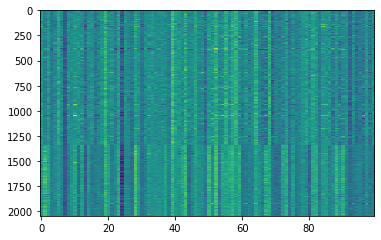

In [171]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_features, interpolation='nearest')
ax.set_aspect(0.03)

In [172]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(ft_doc_features)

cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, 
                              columns=['ClusterLabel'])
print(f"Number of Clusters: {max(ap.labels_)}")


Number of Clusters: 88


#### T-SNE of tunes based on Embeddings

In [173]:
tsne = TSNE(n_components=2, 
            random_state=0,
            perplexity = 70,
            learning_rate=100.0,
            #n_iter_without_progress=200,
            n_iter=5000
            )
#np.set_printoptions(suppress=True)
T = tsne.fit_transform(ft_doc_features)

In [174]:
assert(len(titles) == len(ft_doc_features))

In [175]:
projected = pd.DataFrame(T)
projected['tune'] = titles['title']
#projected['cluster'] = df_cluster['ClusterLabel'].astype(str)
projected['mode'] = meta['tune_mode']

fig = px.scatter(
    projected, 
    x=0, y=1,
    color='mode',
    hover_name='tune',
    width=600, height=500
)
fig.update_traces(textposition='top center')
fig.update_traces(textfont_size=8, selector=dict(type='scatter'))
fig.show()

### Cluster the T-SNE Result

In [177]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311927 sha256=84df82c299f394808f1ff13bbadd23f555b92644eb5edcaf7b604d6a3464ebf8
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [178]:
import hdbscan

In [190]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
clusterer.fit(T)

clusterer.labels_

array([ 0,  0,  0, ...,  3,  3, -1])

In [191]:
clust_proj = pd.DataFrame(T)
clust_proj['tune'] = titles['title']
clust_proj['cluster'] = clusterer.labels_.astype(str)
clust_proj['mode'] = titles['tune_mode']

fig = px.scatter(
    clust_proj, 
    x=0, y=1,
    color='cluster',
    hover_name='tune',
    width=600, height=500
)
fig.update_traces(textposition='top center')
fig.update_traces(textfont_size=8, selector=dict(type='scatter'))
fig.show()

#### Histograms for ngrams for each Cluster

In [196]:
def plot_cluster_histograms(df, cluster, top_n=45):
  tune_ind = df.query(f'cluster=="{cluster}"').index
  tune_ind

  # split chords for each tune
  tune_chords = [tune.split(" ") for tune in tunes]

  # filter the tunes
  tune_chords = [ tune_chords[i] for i in tune_ind ]

  # flatten the filtered tunes
  tune_chords = [item for subl in tune_chords for item in subl]

  counts = Counter(tune_chords)
  df_chords = pd.DataFrame(counts.items(),
                      columns=['chord_ngram', 'count']).sort_values(by='count', ascending=False)

  df_chords = pd.DataFrame.from_dict(df_chords[:top_n])
  df_chords.sort_values(by=['count'], ascending=False, inplace=True)

  fig = px.bar(df_chords, x='chord_ngram', y='count', log_y=True, title=f"Cluster {cluster}")
  fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
  fig.show()

In [197]:
plot_cluster_histograms(clust_proj, cluster=0)

NameError: ignored